In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,make_scorer

In [2]:
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

c:\Users\jacks\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

In [4]:
#import training and testing data
train = pd.read_csv(r"C:\Ziyuan Sui\MSBA\Winter23\Sports Analytics\Passion Project\train_new.csv")
test = pd.read_csv(r"C:\Ziyuan Sui\MSBA\Winter23\Sports Analytics\Passion Project\test2.csv")

In [6]:
#fill null value
train=train.fillna(0)
test=test.fillna(0)

In [7]:
encoded_train = pd.get_dummies(train, columns=['Pos'])

In [8]:
encoded_test = pd.get_dummies(test, columns=['Pos'])

In [68]:
real_test.columns

Index(['G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS',
       'WS/48', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'WinPCT', 'Pos_C', 'Pos_F', 'Pos_G'],
      dtype='object')

In [9]:
encoded_test = encoded_test[encoded_test.G>=43]
encoded_test = encoded_test[encoded_test.MP/encoded_test.G >=30]

In [10]:
real_test = encoded_test.drop(columns=['Team','Player','Age','G','MP'])

In [11]:
real_test.shape

(90, 32)

In [12]:
X = encoded_train.drop(columns=['# Tm','Player','Share','SeasonID','Team','Tm','season','year','Age','G','MP'])
y = encoded_train.Share

In [13]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [62]:
# create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
# set the hyperparameters for the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',

}
# train the model
num_rounds = 100
model = lgb.train(params, train_data, num_rounds)

# make predictions on the test set
y_pred = model.predict(X_test)
# evaluate the model using root mean squared error, R-squared, and mean absolute error
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3980
[LightGBM] [Info] Number of data points in the train set: 1071, number of used features: 32
[LightGBM] [Info] Start training from score 0.226438
RMSE: 0.13351567169670894
R-squared: 0.8133619410446178
MAE: 0.0900352987440867


In [63]:
result7 = model.predict(real_test)
output7 = encoded_test
output7['prediction']=result7
output_guard7 = output7[output7.Pos_G==1].sort_values('prediction',ascending=False)
output_forward7 = output7[output7.Pos_F==1].sort_values('prediction',ascending=False)
output_center7 = output7[output7.Pos_C==1].sort_values('prediction',ascending=False)

In [64]:
first7 = pd.concat([output_guard7.iloc[0:2], output_forward7.iloc[0:2], output_center7.iloc[0:1]])
second7 = pd.concat([output_guard7.iloc[2:4], output_forward7.iloc[2:4], output_center7.iloc[1:2]])
third7 = pd.concat([output_guard7.iloc[4:6], output_forward7.iloc[4:6], output_center7.iloc[2:3]])

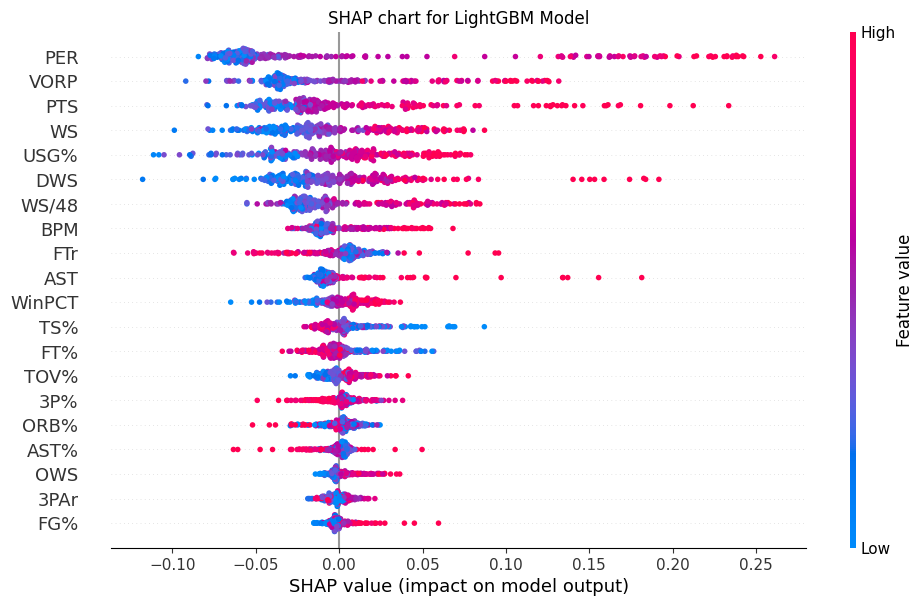

In [65]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,plot_size=(10,6),show=False)
plt.title('SHAP chart for LightGBM Model')
plt.show()

In [32]:
first7

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.674532
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.570993
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.719994
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.637895
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.876062


In [19]:
second7

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.449700
205,Ja Morant,23,53,1721,27.1,6.0,8.2,1.1,0.2,0.463,...,5.6,0.7,6.3,3.6,0.614,Memphis Grizzlies,0,0,1,0.424197
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.530484
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.276728
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.783524


In [20]:
third7

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.371231
230,James Harden,33,52,1911,21.7,6.3,10.8,1.2,0.5,0.446,...,5.7,0.4,6.1,3.9,0.686,Philadelphia 76ers,0,0,1,0.353116
122,DeMar DeRozan,33,64,2343,25.4,4.7,5.1,1.1,0.5,0.513,...,2.0,0.2,2.2,2.4,0.471,Chicago Bulls,0,1,0,0.188863
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.170336
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,0.311218


SVM

In [35]:
# create an SVM model
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.1528988825390595
R-squared: 0.7552378034693399
MAE: 0.10722346132765934


In [36]:
result4 = model.predict(real_test)
output4 = encoded_test
output4['prediction']=result4
output_guard4 = output4[output4.Pos_G==1].sort_values('prediction',ascending=False)
output_forward4 = output4[output4.Pos_F==1].sort_values('prediction',ascending=False)
output_center4 = output4[output4.Pos_C==1].sort_values('prediction',ascending=False)

In [38]:
first4 = pd.concat([output_guard4.iloc[0:2], output_forward4.iloc[0:2], output_center4.iloc[0:1]])
second4 = pd.concat([output_guard4.iloc[2:4], output_forward4.iloc[2:4], output_center4.iloc[1:2]])
third4 = pd.concat([output_guard4.iloc[4:6], output_forward4.iloc[4:6], output_center4.iloc[2:3]])

In [39]:
first4

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.664947
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.539927
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.715477
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.535574
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.937881


In [40]:
second4

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.462639
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.326410
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.359537
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.284373
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.847293


In [41]:
third4

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
500,Stephen Curry,34,46,1597,29.8,6.2,6.2,0.9,0.3,0.499,...,7.8,0.1,7.9,4.0,0.500,Golden State Warriors,0,0,1,0.295333
230,James Harden,33,52,1911,21.7,6.3,10.8,1.2,0.5,0.446,...,5.7,0.4,6.1,3.9,0.686,Philadelphia 76ers,0,0,1,0.285624
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.279503
122,DeMar DeRozan,33,64,2343,25.4,4.7,5.1,1.1,0.5,0.513,...,2.0,0.2,2.2,2.4,0.471,Chicago Bulls,0,1,0,0.179953
23,Anthony Davis,29,45,1511,26.1,12.5,2.6,1.0,2.0,0.562,...,4.7,1.8,6.5,3.2,0.479,Los Angeles Lakers,1,0,0,0.388325


Linear Regression

In [256]:
# create a linear regression model
model = LinearRegression()

# train the model
model.fit(scaled_X_train, y_train)

# make predictions on the test set
y_pred = model.predict(scaled_X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.15943519965125266
R-squared: 0.7338636850765059
MAE: 0.12480229557856541


In [257]:
result6 = model.predict(real_test)
output6 = encoded_test
output6['prediction']=result6
output_guard6 = output6[output6.Pos_G==1].sort_values('prediction',ascending=False)
output_forward6 = output6[output6.Pos_F==1].sort_values('prediction',ascending=False)
output_center6 = output6[output6.Pos_C==1].sort_values('prediction',ascending=False)

In [258]:
first6 = pd.concat([output_guard6.iloc[0:2], output_forward6.iloc[0:2], output_center6.iloc[0:1]])
second6 = pd.concat([output_guard6.iloc[2:4], output_forward6.iloc[2:4], output_center6.iloc[1:2]])
third6 = pd.concat([output_guard6.iloc[4:6], output_forward6.iloc[4:6], output_center6.iloc[2:3]])

In [259]:
first6

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,2.333994
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,2.192883
351,Lauri Markkanen,25,63,2169,25.4,8.6,1.8,0.6,0.6,0.503,...,4.9,-1.1,3.8,3.2,0.486,Utah Jazz,0,1,0,2.869782
429,OG Anunoby,25,57,2036,16.7,5.1,1.9,2.0,0.7,0.472,...,-0.8,0.7,-0.1,1.0,0.493,Toronto Raptors,0,1,0,2.366721
23,Anthony Davis,29,45,1511,26.1,12.5,2.6,1.0,2.0,0.562,...,4.7,1.8,6.5,3.2,0.479,Los Angeles Lakers,1,0,0,2.553719


In [260]:
second6

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
176,Gary Trent Jr.,24,62,2021,17.7,2.6,1.6,1.6,0.2,0.436,...,0.2,0.0,0.2,1.1,0.493,Toronto Raptors,0,0,1,2.181501
339,Klay Thompson,32,60,1972,21.9,4.1,2.5,0.7,0.4,0.435,...,1.5,-1.9,-0.4,0.8,0.500,Golden State Warriors,0,0,1,2.050954
247,Jaylen Brown,26,60,2170,26.7,6.9,3.4,1.2,0.4,0.490,...,1.7,-0.3,1.5,1.9,0.681,Boston Celtics,0,1,0,2.284286
254,Jerami Grant,28,63,2246,20.5,4.5,2.4,0.8,0.8,0.475,...,1.3,-1.4,-0.1,1.1,0.443,Portland Trail Blazers,0,1,0,2.245426
48,Brook Lopez,34,68,2087,15.5,6.7,1.3,0.5,2.5,0.519,...,0.7,1.4,2.1,2.2,0.714,Milwaukee Bucks,1,0,0,2.521275


In [261]:
third6

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
565,Zach LaVine,27,66,2391,25.0,4.7,4.1,0.9,0.2,0.482,...,2.7,-0.8,1.8,2.3,0.471,Chicago Bulls,0,0,1,2.005296
24,Anthony Edwards,21,71,2558,24.7,5.9,4.4,1.6,0.7,0.461,...,1.1,-0.1,1.0,1.9,0.486,Minnesota Timberwolves,0,0,1,1.698833
39,Bojan Bogdanović,33,59,1893,21.6,3.8,2.6,0.6,0.1,0.488,...,2.6,-1.8,0.8,1.4,0.222,Detroit Pistons,0,1,0,2.072939
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,1.887798
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,2.519291


Decision Tree

In [21]:
# create a decision tree model
model = DecisionTreeRegressor()

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.2269830357261588
R-squared: 0.4605856207258414
MAE: 0.13508955223880595


In [22]:
result8 = model.predict(real_test)
output8 = encoded_test
output8['prediction']=result8
output_guard8 = output8[output8.Pos_G==1].sort_values('prediction',ascending=False)
output_forward8 = output8[output8.Pos_F==1].sort_values('prediction',ascending=False)
output_center8 = output8[output8.Pos_C==1].sort_values('prediction',ascending=False)

In [23]:
first8 = pd.concat([output_guard8.iloc[0:2], output_forward8.iloc[0:2], output_center8.iloc[0:1]])
second8 = pd.concat([output_guard8.iloc[2:4], output_forward8.iloc[2:4], output_center8.iloc[1:2]])
third8 = pd.concat([output_guard8.iloc[4:6], output_forward8.iloc[4:6], output_center8.iloc[2:3]])

In [24]:
first8

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
230,James Harden,33,52,1911,21.7,6.3,10.8,1.2,0.5,0.446,...,5.7,0.4,6.1,3.9,0.686,Philadelphia 76ers,0,0,1,0.977
500,Stephen Curry,34,46,1597,29.8,6.2,6.2,0.9,0.3,0.499,...,7.8,0.1,7.9,4.0,0.500,Golden State Warriors,0,0,1,0.964
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.946
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.704
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,1.000


In [25]:
second8

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.876
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.852
247,Jaylen Brown,26,60,2170,26.7,6.9,3.4,1.2,0.4,0.490,...,1.7,-0.3,1.5,1.9,0.681,Boston Celtics,0,1,0,0.550
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.409
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,1.000


Random Forest

In [55]:
# create a random forest model
model = RandomForestRegressor(n_estimators=100)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.1424120761350823
R-squared: 0.7876612019124247
MAE: 0.09797462686567163


In [56]:
result = model.predict(real_test)
output = encoded_test
output['prediction']=result
output_guard = output[output.Pos_G==1].sort_values('prediction',ascending=False)
output_forward = output[output.Pos_F==1].sort_values('prediction',ascending=False)
output_center = output[output.Pos_C==1].sort_values('prediction',ascending=False)

In [57]:
first = pd.concat([output_guard.iloc[0:2], output_forward.iloc[0:2], output_center.iloc[0:1]])
second = pd.concat([output_guard.iloc[2:4], output_forward.iloc[2:4], output_center.iloc[1:2]])
third = pd.concat([output_guard.iloc[4:6], output_forward.iloc[4:6], output_center.iloc[2:3]])

In [58]:
first

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.69540
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.52754
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.60358
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.54912
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.82640


In [59]:
second

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.47108
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.43238
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.51021
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.25373
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.81112


In [60]:
third

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
230,James Harden,33,52,1911,21.7,6.3,10.8,1.2,0.5,0.446,...,5.7,0.4,6.1,3.9,0.686,Philadelphia 76ers,0,0,1,0.37589
205,Ja Morant,23,53,1721,27.1,6.0,8.2,1.1,0.2,0.463,...,5.6,0.7,6.3,3.6,0.614,Memphis Grizzlies,0,0,1,0.34976
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.21053
122,DeMar DeRozan,33,64,2343,25.4,4.7,5.1,1.1,0.5,0.513,...,2.0,0.2,2.2,2.4,0.471,Chicago Bulls,0,1,0,0.16361
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,0.28604


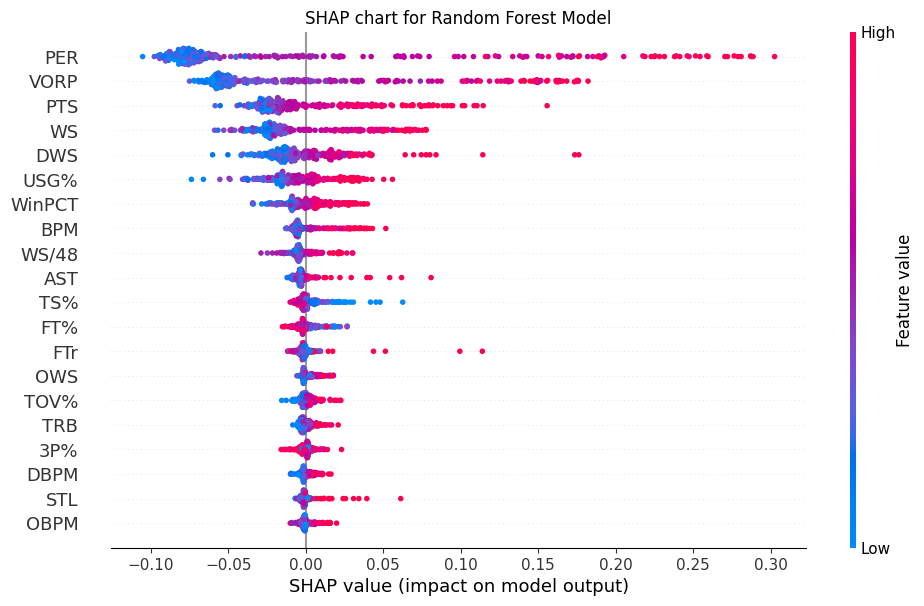

In [61]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,plot_size=(10,6),show=False)
plt.title('SHAP chart for Random Forest Model')
plt.show()

In [21]:
# create a Random Forest regressor
model = RandomForestRegressor()

# define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

In [22]:
# define the scoring metric as RMSE
scoring = make_scorer(mean_squared_error, squared=False)

# perform the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring)
grid_search.fit(X_train, y_train)

# print the best hyperparameters found by the grid search
print('Best parameters:', grid_search.best_params_)

# make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# evaluate the model using RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

Best parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
RMSE: 0.18218681974661213


XGBoost

In [44]:
# create an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.1391363848154932
R-squared: 0.7973170816202043
MAE: 0.09258865479801616


In [45]:
result2 = model.predict(real_test)
output2 = encoded_test
output2['prediction']=result2
output_guard2 = output2[output2.Pos_G==1].sort_values('prediction',ascending=False)
output_forward2 = output2[output2.Pos_F==1].sort_values('prediction',ascending=False)
output_center2 = output2[output2.Pos_C==1].sort_values('prediction',ascending=False)

In [46]:
first2 = pd.concat([output_guard2.iloc[0:2], output_forward2.iloc[0:2], output_center2.iloc[0:1]])
second2 = pd.concat([output_guard2.iloc[2:4], output_forward2.iloc[2:4], output_center2.iloc[1:2]])
third2 = pd.concat([output_guard2.iloc[4:6], output_forward2.iloc[4:6], output_center2.iloc[2:3]])

In [47]:
first2

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.861178
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.654772
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.529089
247,Jaylen Brown,26,60,2170,26.7,6.9,3.4,1.2,0.4,0.490,...,1.7,-0.3,1.5,1.9,0.681,Boston Celtics,0,1,0,0.344766
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.915911


In [48]:
second2

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.545145
500,Stephen Curry,34,46,1597,29.8,6.2,6.2,0.9,0.3,0.499,...,7.8,0.1,7.9,4.0,0.500,Golden State Warriors,0,0,1,0.450540
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.333378
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.307854
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.884360


In [49]:
third2

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
230,James Harden,33,52,1911,21.7,6.3,10.8,1.2,0.5,0.446,...,5.7,0.4,6.1,3.9,0.686,Philadelphia 76ers,0,0,1,0.321121
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.319551
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.307746
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.156868
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,0.408102


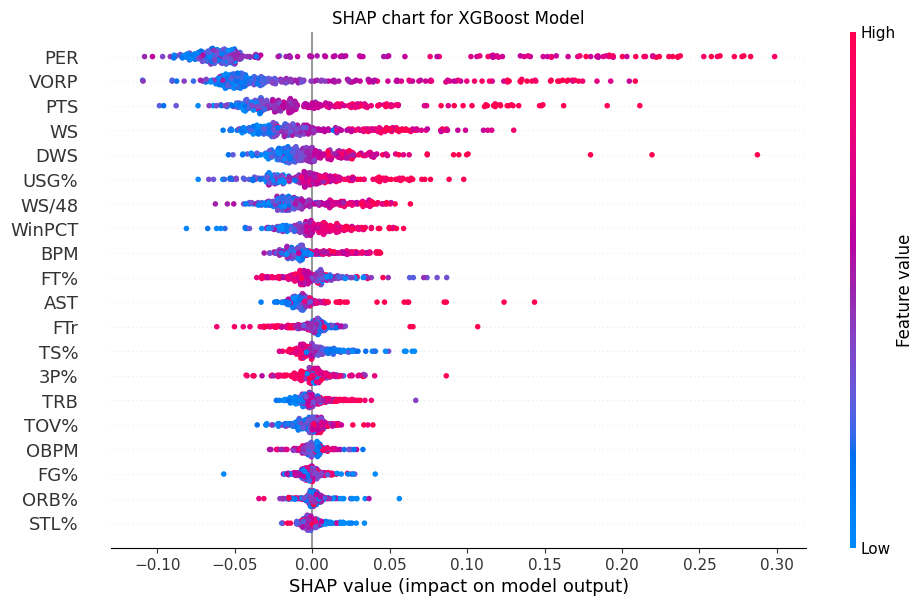

In [54]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test,plot_size=(10,6),show=False)
plt.title('SHAP chart for XGBoost Model')
plt.show()

In [28]:
# Set up XGBoost regression model
xgb_model = xgb.XGBRegressor()

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04,0.05],
    'max_depth': range(2,9,1),
    'n_estimators': [100, 150,200, 250]
    
}

# Define GridSearchCV with XGBoost model and hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the testing data
y_pred = grid_search.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE: ", rmse)

Best hyperparameters:  {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 250}
Best score:  -0.18406970733915898
RMSE:  0.14405646383863246


CatBoost

In [275]:
# create a CatBoost model
model = CatBoostRegressor(iterations=100, loss_function='RMSE')

# train the model
model.fit(X_train, y_train, verbose=False)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.14697514828705702
R-squared: 0.773835970496192
MAE: 0.0979417866782742


In [276]:
result3 = model.predict(real_test)
output3 = encoded_test
output3['prediction']=result3
output_guard3 = output3[output3.Pos_G==1].sort_values('prediction',ascending=False)
output_forward3 = output3[output3.Pos_F==1].sort_values('prediction',ascending=False)
output_center3 = output3[output3.Pos_C==1].sort_values('prediction',ascending=False)

In [277]:
first3 = pd.concat([output_guard3.iloc[0:2], output_forward3.iloc[0:2], output_center3.iloc[0:1]])
second3 = pd.concat([output_guard3.iloc[2:4], output_forward3.iloc[2:4], output_center3.iloc[1:2]])
third3 = pd.concat([output_guard3.iloc[4:6], output_forward3.iloc[4:6], output_center3.iloc[2:3]])

In [279]:
first3

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.699498
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.563590
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.720791
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.548616
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.919045


In [280]:
second3

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
205,Ja Morant,23,53,1721,27.1,6.0,8.2,1.1,0.2,0.463,...,5.6,0.7,6.3,3.6,0.614,Memphis Grizzlies,0,0,1,0.534996
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.503531
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.534937
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.335404
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.814932


In [221]:
third3

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
500,Stephen Curry,34,46,1597,29.8,6.2,6.2,0.9,0.3,0.499,...,7.8,0.1,7.9,4.0,0.500,Golden State Warriors,0,0,1,0.449772
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.397452
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.186571
247,Jaylen Brown,26,60,2170,26.7,6.9,3.4,1.2,0.4,0.490,...,1.7,-0.3,1.5,1.9,0.681,Boston Celtics,0,1,0,0.172234
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,0.445130


AdaBoost

In [282]:
# create an AdaBoost model
model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model using RMSE, R-squared, and MAE
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('RMSE:', rmse)
print('R-squared:', r2)
print('MAE:', mae)

RMSE: 0.16249703009282174
R-squared: 0.7235436466736971
MAE: 0.12814929734846417


In [283]:
result5 = model.predict(real_test)
output5 = encoded_test
output5['prediction']=result5
output_guard5 = output5[output5.Pos_G==1].sort_values('prediction',ascending=False)
output_forward5 = output5[output5.Pos_F==1].sort_values('prediction',ascending=False)
output_center5 = output5[output5.Pos_C==1].sort_values('prediction',ascending=False)

In [284]:
first5 = pd.concat([output_guard5.iloc[0:2], output_forward5.iloc[0:2], output_center5.iloc[0:1]])
second5 = pd.concat([output_guard5.iloc[2:4], output_forward5.iloc[2:4], output_center5.iloc[1:2]])
third5 = pd.concat([output_guard5.iloc[4:6], output_forward5.iloc[4:6], output_center5.iloc[2:3]])

In [285]:
first5

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
358,Luka Dončić,23,57,2068,33.0,8.6,8.0,1.5,0.5,0.500,...,7.9,1.6,9.5,6.0,0.507,Dallas Mavericks,0,0,1,0.614777
493,Shai Gilgeous-Alexander,24,59,2100,31.3,4.8,5.5,1.7,1.0,0.511,...,5.8,1.5,7.3,4.9,0.493,Oklahoma City Thunder,0,0,1,0.505826
180,Giannis Antetokounmpo,28,55,1784,31.4,11.9,5.5,0.7,0.8,0.542,...,5.6,2.5,8.0,4.5,0.714,Milwaukee Bucks,0,1,0,0.606857
250,Jayson Tatum,24,67,2508,30.0,8.9,4.7,1.0,0.7,0.457,...,4.6,0.4,5.0,4.4,0.681,Boston Celtics,0,1,0,0.548384
264,Joel Embiid,28,57,1986,33.5,10.2,4.2,1.1,1.7,0.546,...,6.8,2.3,9.1,5.6,0.686,Philadelphia 76ers,1,0,0,0.806211


In [286]:
second5

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
93,Damian Lillard,32,56,2034,32.4,4.7,7.2,0.9,0.3,0.467,...,8.5,-1.2,7.3,4.8,0.443,Portland Trail Blazers,0,0,1,0.490316
141,Donovan Mitchell,26,61,2165,27.4,4.1,4.6,1.5,0.4,0.477,...,5.3,0.7,6.0,4.4,0.616,Cleveland Cavaliers,0,0,1,0.490316
259,Jimmy Butler,33,57,1897,22.6,6.1,5.0,1.9,0.4,0.527,...,6.4,2.0,8.4,5.0,0.534,Miami Heat,0,1,0,0.440146
353,LeBron James,38,47,1695,29.5,8.4,6.9,0.9,0.6,0.501,...,5.6,0.7,6.3,3.5,0.479,Los Angeles Lakers,0,1,0,0.422735
422,Nikola Jokić,27,63,2136,24.8,11.8,9.9,1.2,0.7,0.633,...,8.6,4.3,12.9,8.0,0.667,Denver Nuggets,1,0,0,0.747452


In [287]:
third5

,Player,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,...,OBPM,DBPM,BPM,VORP,WinPCT,Team,Pos_C,Pos_F,Pos_G,prediction
205,Ja Morant,23,53,1721,27.1,6.0,8.2,1.1,0.2,0.463,...,5.6,0.7,6.3,3.6,0.614,Memphis Grizzlies,0,0,1,0.483495
500,Stephen Curry,34,46,1597,29.8,6.2,6.2,0.9,0.3,0.499,...,7.8,0.1,7.9,4.0,0.500,Golden State Warriors,0,0,1,0.426796
351,Lauri Markkanen,25,63,2169,25.4,8.6,1.8,0.6,0.6,0.503,...,4.9,-1.1,3.8,3.2,0.486,Utah Jazz,0,1,0,0.260088
299,Julius Randle,28,72,2586,25.2,10.3,4.1,0.7,0.3,0.457,...,4.0,-0.1,3.9,3.8,0.583,New York Knicks,0,1,0,0.182531
139,Domantas Sabonis,26,68,2360,19.2,12.5,7.2,0.8,0.5,0.612,...,4.1,1.9,5.9,4.7,0.614,Sacramento Kings,1,0,0,0.471172


functions

In [67]:
# Function for metrics
def func_metricas(y_test, y_pred, metric, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [78]:
def func_model(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
                # Separating training and testing bases
        season_test = season

        data_train = data[data['season']!=season_test]
        data_test = data[data['season']==season_test]

        X_train = data_train.drop(['#Tm','Player','Share','SeasonID','Team','Tm','season','year','Age'], axis=1)
        y_train = data_train['Share']

        X_test = data_test.drop(['#Tm','Player','Share','SeasonID','Team','Tm','season','year','Age'], axis=1)
        y_test = data_test['Share']

        initial_results = data_test[['Player','season','Share']]
        results = initial_results.copy()

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(X_train, y_train)
                model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

              
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(X_train, y_train)
                model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(X_train, y_train)
                model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='XGBoost':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5,6,7]}
                xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
                grid = GridSearchCV(xgb_model, param_grid)
                grid.fit(X_train, y_train)
                model = xgb.XGBRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4,5],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor( objective='regression',metric='rmse')
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(X_train, y_train)
                model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            model.fit(X_train, y_train)
            
            pickle.dump(model,open(path_data+sep+'Modelos'+sep+model+'.dat'),'wb')
            
            y_pred = model.predict(scaled_X_test)
            metrics = func_metricas(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MVP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MVP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MVP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MVP Votes Share','MVP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    
    
    return final_results, metrics, best_params

In [75]:
def media_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Modelo': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        apoio = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,apoio], ignore_index=True)
    return final_metrics

In [80]:
seasons = ['1988-89', '1989-90', '1990-91', '1991-92', '1992-93', '1993-94',
       '1994-95', '1995-96', '1996-97', '1997-98', '1998-99', '1999-00',
       '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18',
       '2018-19', '2019-20', '2020-21', '2021-22'] 
           
models = ['SVM','Random Forest','AdaBoost','XGBoost','LGBM']
data = encoded_train

In [81]:
final_results, metrics, best_params = func_model(data, seasons, models, 1)
final_metrics = media_metrics(metrics)
final_metrics